In [263]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from source.anomalyDetector import AnomalyDetector

## Autoencoder

#### Reading the data

In [344]:
ds_2025 = xr.open_dataset("files/2025_KVS_deployment_flagged.nc")
ds_2024 = xr.open_dataset("files/2024_KVS_deployment_flagged.nc")

In [345]:
ds_2025_1m_temp = ds_2025["temp_1m_calibrated"]
ds_2025_ir_temp = ds_2025["temp_snowsurface"]
ds_2025["temp_diff"] = ds_2025_1m_temp - ds_2025_ir_temp

ds_2024_1m_temp = ds_2024["temp_1m_calibrated"]
ds_2024_ir_temp = ds_2024["temp_snowsurface_calibrated"]
ds_2024["temp_diff"] = ds_2024_1m_temp - ds_2024_ir_temp

need to figure out what is wrong with bouy 5 and 12 but for now, bye bye

The data is now formatted as a matrix where the last column is the flags, the first is the 1m-temperature values, and the middle is the diff between 1m-temperature and surface temperature.

We then split the data into train and test.

In [361]:
import importlib
import source.data_wrangling as dw
importlib.reload(dw)

variables = ["temp_1m_calibrated","temp_diff","temp_1m_quality_flag"]

dataset_2025 = dw.pool_data_variables(ds_2025,variables,[5,12,13],False)
#print(dataset_2025)

dataset_2024 = dw.pool_data_variables(ds_2024,
                                      variables,
                                      [1, 2, 3, 4, 6, 7, 8, 10,
                                        12, 13, 14, 15, 16, 17, 18, 
                                        19, 21, 22, 23, 24, 25, 28, 32],
                                      False)

In [364]:
data = dataset_2025["temp_diff"]
labels = dataset_2025["temp_1m_quality_flag"]

In [365]:
train_data,test_data,train_labels,test_labels = train_test_split(data,
                                                                 labels,
                                                                 test_size=0.2)



#### Scaling the data

Text(0.5, 1.0, 'Test data,\n 1m - surface 2025')

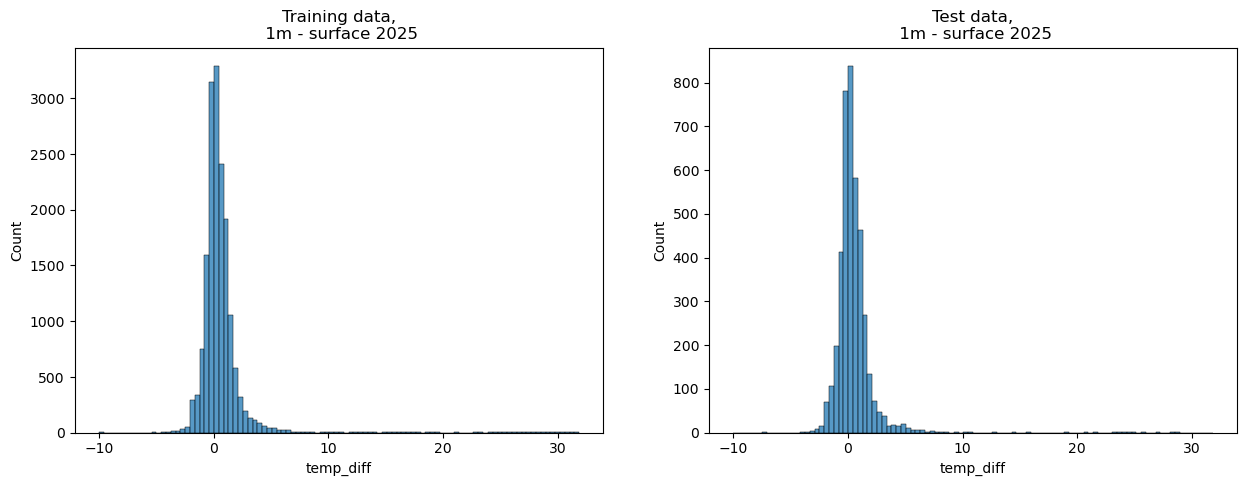

In [366]:
fig = plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(train_data, bins=100)

ax = plt.subplot(1,2,1)
sns.histplot(train_data,ax=ax,bins=bins)
ax.set_title("Training data,\n 1m - surface 2025")


ax1 = plt.subplot(1,2,2)
sns.histplot(test_data,ax=ax1,bins=bins)
ax1.set_title("Test data,\n 1m - surface 2025")

In [222]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [223]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam',loss='mae')

In [224]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 1.1648 - val_loss: 1.0325
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1630 - val_loss: 1.0316
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1605 - val_loss: 1.0302
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1570 - val_loss: 1.0283
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1524 - val_loss: 1.0257
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1463 - val_loss: 1.0222
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1383 - val_loss: 1.0175
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1278 - val_loss: 1.0114
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1144 - val_loss: 1.0034
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0975 - val_loss: 0.9932
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0763 - val_loss: 0.9805
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0510 - val_loss: 0.9652
E

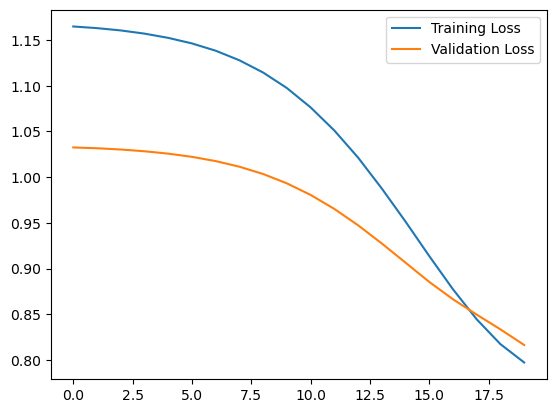

In [225]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


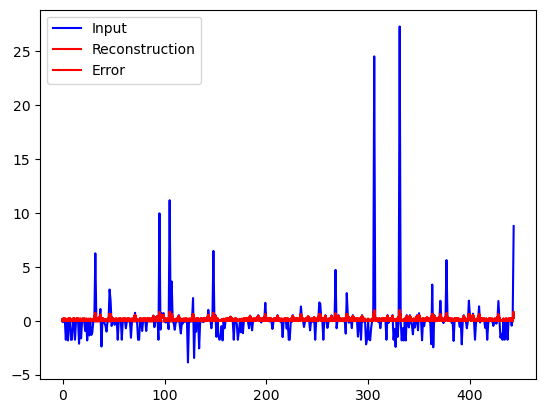

In [230]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data, 'b')
plt.plot(decoded_data, 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


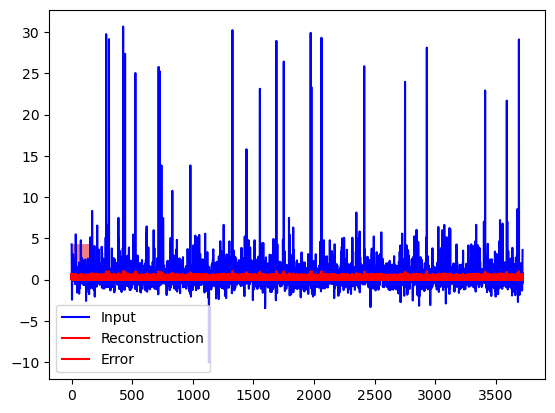

In [231]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data, 'b')
plt.plot(decoded_data, 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. 

In [234]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


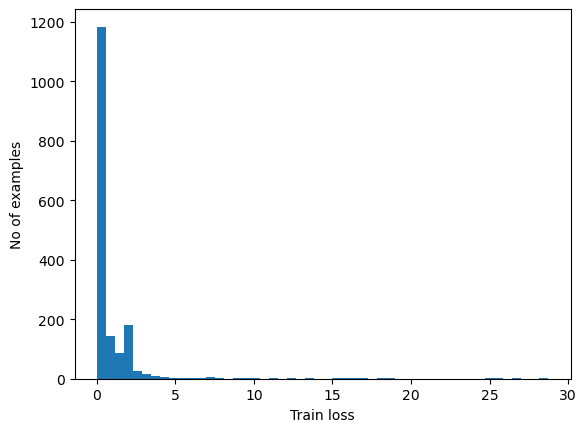

In [235]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [236]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  2.982936582786745


In [237]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


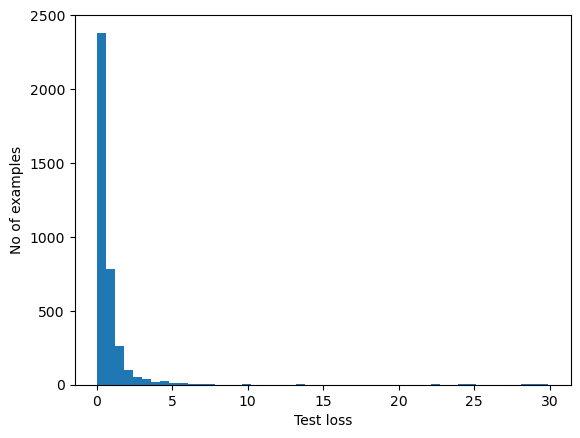

In [239]:
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [259]:
import importlib
import source.anomalyDetector as AD
importlib.reload(AD)

<module 'source.anomalyDetector' from '/home/jotje3041/thesis_2_electric_boogaloo/fystek-assignments/source/anomalyDetector.py'>

In [260]:
preds = AD.anomalyPredict(autoencoder, test_data, threshold)
AD.print_stats(preds, test_labels)

Accuracy = 0.13822894168466524
Precision = 0.10770381451009724
Recall = 0.972972972972973


In [261]:
preds

<tf.Tensor: shape=(4167,), dtype=bool, numpy=array([False,  True,  True, ...,  True,  True, False])>